<a href="https://colab.research.google.com/github/NabiAdnan/Solar-Cell-PCE-prediction/blob/main/Solar_PCE_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error

In [ ]:
df = pd.read_csv("/content/Solar Cell data set.csv", low_memory=False)

In [ ]:
# Rename for clarity
df = df.rename(columns={'JV_default_PCE': 'PCE'})

In [ ]:
# Drop rows without PCE
df = df[df['PCE'].notna()]

In [ ]:
# Separate features and target
X = df.drop(columns=['PCE'])
y = df['PCE']

In [ ]:
# Identify column types
num_cols = [c for c in X.columns if np.issubdtype(X[c].dtype, np.number)]
cat_cols = [c for c in X.columns if X[c].dtype == 'object']
bool_cols = [c for c in X.columns if X[c].dtype == 'bool']

In [ ]:
# 3️⃣ Preprocessing pipelines
# ============================================================
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

bool_transformer = 'passthrough'

preprocessor = ColumnTransformer([
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols),
    ('bool', bool_transformer, bool_cols)
])

In [ ]:
# 4️⃣ Model pipeline
# ============================================================
model = Pipeline([
    ('preprocessor', preprocessor),
    ('select', SelectKBest(f_regression, k=200)),
    ('regressor', HistGradientBoostingRegressor(max_depth=6, learning_rate=0.1, max_iter=200, random_state=42))
])

In [ ]:
# 5️⃣ Split and train
# ============================================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Perovskite_deposition_number_of_deposition_steps',
                                                   'JV_default_Voc',
                                                   'JV_default_Jsc',
                                                   'JV_default_FF']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot'...
                                                   'Backcontact_deposition_procedure',
                                                   'Encapsulation_stack_sequence']),
                                                 ('bool', 'passthrough',
                                                  ['Perovskite_deposition_quenching_induced_crystallisation',
                                                   'Encapsulation',
                                                   'JV_measured'])])),
                ('select',
                 SelectKBest(k=200,
                             score_func=<function f_regression at 0x7eff4d18ce00>)),
                ('regressor',
                 HistGradientBoostingRegressor(max_depth=6, max_iter=200,
                                               random_state=42))])

In [ ]:
# 6️⃣ Evaluate
# ============================================================
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("==============================================")
print("🔍 MODEL PERFORMANCE")
print("==============================================")
print(f"✅ R² Score : {r2:.4f}")
print(f"✅ RMSE     : {rmse:.4f}")
print("==============================================")

🔍 MODEL PERFORMANCE
✅ R² Score : 0.9410
✅ RMSE     : 1.2717


In [ ]:
import pandas as pd
import numpy as np

# ✅ Assume the model is already trained using the previous code

def predict_pce(input_data: dict, model, reference_df: pd.DataFrame):
    """
    Predict PCE (Power Conversion Efficiency) for new material/process input.

    Parameters:
    -----------
    input_data : dict
        Example:
        {
          'Material': 'CsFAMAPbBrI',
          'Temperature': 120,
          'Annealing_Time': 30,
          'Substrate': 'ITO',
          'Solvent': 'DMF:DMSO'
        }
    model : trained sklearn pipeline
        The trained model pipeline (with preprocessing)
    reference_df : pd.DataFrame
        The original training DataFrame (used for consistent columns)

    Returns:
    --------
    float
        Predicted PCE value.
    """


    # Convert dictionary to DataFrame
    input_df = pd.DataFrame([input_data])

    # Ensure all expected columns exist
    missing_cols = [col for col in reference_df.drop(columns=['PCE']).columns if col not in input_df.columns]
    for col in missing_cols:
        input_df[col] = np.nan  # fill missing columns

    for col in missing_cols:
    # fill with mode for categorical or median for numeric
      if reference_df[col].dtype == 'object':
          input_df[col] = reference_df[col].mode()[0]
      else:
          input_df[col] = reference_df[col].median()


    # Align column order
    input_df = input_df[reference_df.drop(columns=['PCE']).columns]

    # Predict
    prediction = model.predict(input_df)[0]

    print(f"🔮 Predicted Power Conversion Efficiency (PCE): {prediction:.2f}%")
    return prediction


In [ ]:
# Example input — fill with your parameters/values
sample_input = {
    'Perovskite_Composition': 'CsFAMAPbBrI',
    'Annealing_Temp': 100,
    'Annealing_Time': 20,
    'Substrate': 'ITO',
    'Solvent': 'DMF:DMSO'
}

# Call the function
predicted_value = predict_pce(sample_input, model, df)


🔮 Predicted Power Conversion Efficiency (PCE): 12.95%


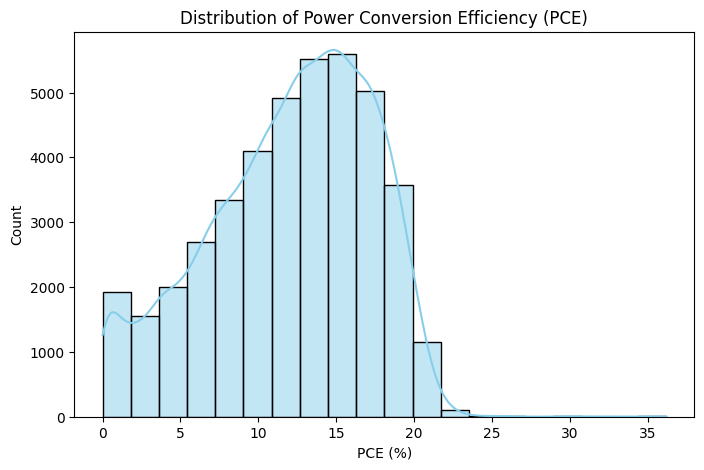

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(df['PCE'], kde=True, color='skyblue', bins=20)
plt.title("Distribution of Power Conversion Efficiency (PCE)")
plt.xlabel("PCE (%)")
plt.ylabel("Count")
plt.show()


In [ ]:
print(df.columns)


Index(['Cell_stack_sequence', 'Cell_architecture', 'Substrate_stack_sequence',
       'ETL_stack_sequence', 'ETL_deposition_procedure',
       'Perovskite_composition_a_ions', 'Perovskite_composition_b_ions',
       'Perovskite_composition_c_ions', 'Perovskite_composition_short_form',
       'Perovskite_additives_compounds', 'Perovskite_additives_concentrations',
       'Perovskite_thickness',
       'Perovskite_deposition_number_of_deposition_steps',
       'Perovskite_deposition_procedure', 'Perovskite_deposition_solvents',
       'Perovskite_deposition_quenching_induced_crystallisation',
       'Perovskite_deposition_thermal_annealing_temperature',
       'Perovskite_deposition_thermal_annealing_time', 'HTL_stack_sequence',
       'HTL_deposition_procedure', 'Backcontact_stack_sequence',
       'Backcontact_thickness_list', 'Backcontact_deposition_procedure',
       'Encapsulation', 'Encapsulation_stack_sequence', 'JV_measured',
       'JV_default_Voc', 'JV_default_Jsc', 'JV_default

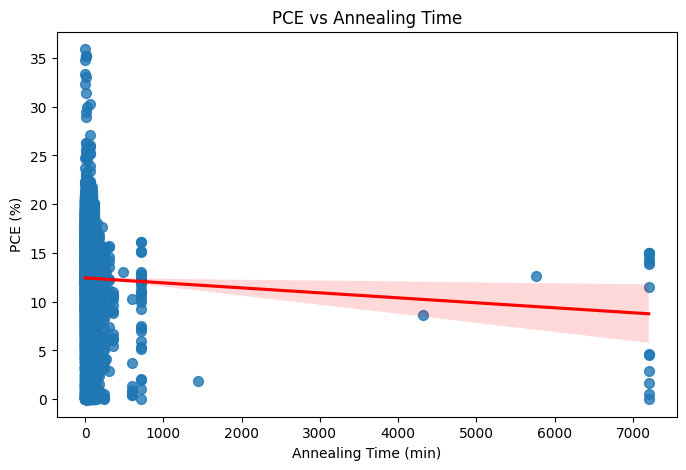

In [ ]:
# Convert columns to numeric, coercing errors to NaN
df['Perovskite_deposition_thermal_annealing_time'] = pd.to_numeric(
    df['Perovskite_deposition_thermal_annealing_time'], errors='coerce'
)

df['Perovskite_deposition_thermal_annealing_temperature'] = pd.to_numeric(
    df['Perovskite_deposition_thermal_annealing_temperature'], errors='coerce'
)

df['PCE'] = pd.to_numeric(df['PCE'], errors='coerce')

df_plot = df.dropna(subset=[
    'Perovskite_deposition_thermal_annealing_time',
    'Perovskite_deposition_thermal_annealing_temperature',
    'PCE'
])

plt.figure(figsize=(8,5))
sns.regplot(
    x='Perovskite_deposition_thermal_annealing_time',
    y='PCE',
    data=df_plot,
    scatter_kws={'s':50},
    line_kws={'color':'red'}
)
plt.title("PCE vs Annealing Time")
plt.xlabel("Annealing Time (min)")
plt.ylabel("PCE (%)")
plt.show()


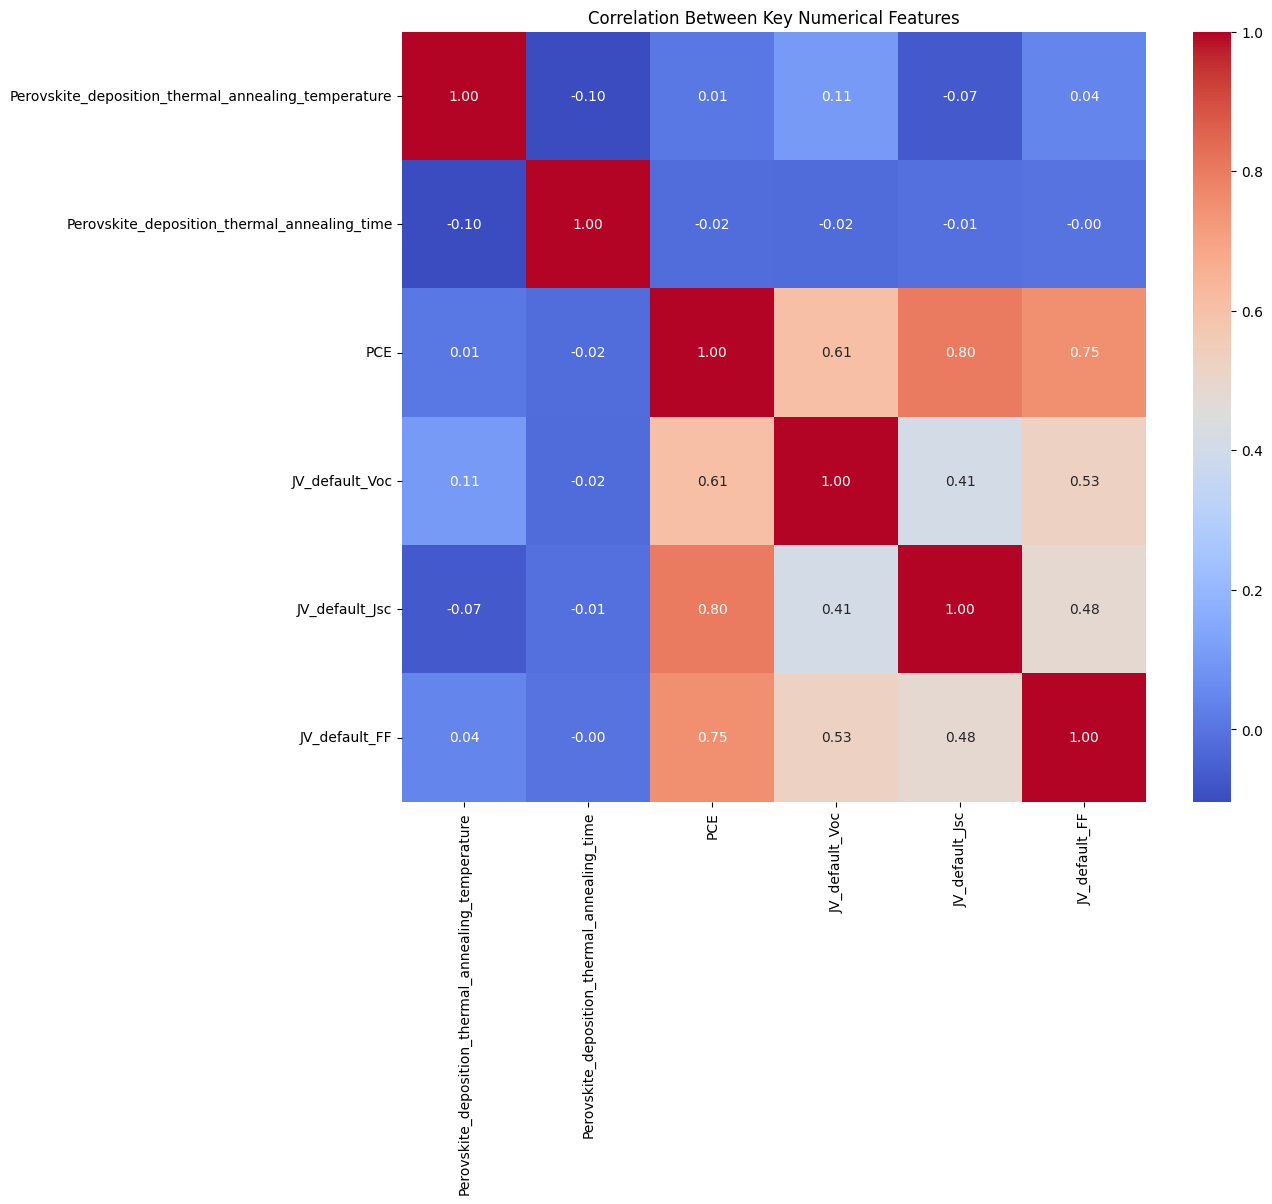

In [ ]:
plt.figure(figsize=(12,10))
numeric_cols = ['Perovskite_deposition_thermal_annealing_temperature',
                'Perovskite_deposition_thermal_annealing_time',
                'PCE',
                'JV_default_Voc', 'JV_default_Jsc', 'JV_default_FF']
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Key Numerical Features")
plt.show()


In [ ]:
# Example input — fill with your parameters/values
sample_input = {
    'Perovskite_Composition': 'CsFAMAPbBrI',
    'Annealing_Temp': 100,
    'Annealing_Time': 20,
    'Substrate': 'ITO',
    'Solvent': 'DMF:DMSO'
}

# Call the function
predicted_value = predict_pce(sample_input, model, df)

🔮 Predicted Power Conversion Efficiency (PCE): 13.02%
